# Introduction

This notebook is the second in the Makemore series. In part 1 we implemented Makemore using a bigram model. We looked at ONE previous character and produced a probability distribution of what character is likely to come next. We did that using two different approaches and reached the same results. First, we used counts and normalized them into probabilities. Second, we used a simple neural network (i.e. linear layer) to produce those same probabilities.

The limit of our implementation in part 1 is that it only looks at ONE previous character; and because the bigram model took only ONE character as context, the prediction of the bigram were **not** good. If we were to use consider MORE than one character when predicting the next one, the approach we used in part-1 (storing everything in a tensor) becomes unsustainable because _the number of combinations we will have to store in a tensor grows exponentially with the amount characters we take as context_. For instance, if we were to take just three characters as context when making a prediction, we would have to store $27 \times 27 \times 27 = 19683$ possibilities in a tensor. That's way to many possibilities, the majority of these possibilities will have very few counts, Andrej said.

That's why for this second part, we are moving away from the Bigram model. This time, we are implementing a Multi-Layer Percepton to predict the next character. The modeling approach we are going to adopt follows the paper: [Bengio et al. 2003](https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf) 

# Bengio et al. 2003 (MLP language model) paper walkthrough

This paper, Andrej said, is not the first to have proposed the use of MLPs to predict the next character/token in a sequence, but was very influencial and is very often cited. Since the paper is long ($19$ pages) Andrej decided to give us gist of it, but invited us to read the entire work. This paper is what we are going to implement in this notebook.

# Re-building our training dataset

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # For making figures
%matplotlib inline

In [2]:
# Read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
len(words)

32033

Now we build the vocabulary of characters and mapping from/to integers. It is important to recall that we are building a character-level language model, unlike the paper who is describing a word-level language model.

In [4]:
# Build the vocabulary of characters and mapping to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i + 1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


We now want to set up the dataset such that we can feed training examples to the neural network easily. We are going to refurbish code we wrote in the previous tutorial. To form the dataset in the first part, we added the first part of the bigram (the context) in a tensor, `xs`... and the second part (the correct prediction) in another tensor, `ys`. 

We are doing something very similar here, but this time Andrej is adding MORE than ONE character as context. `X` will store the input of the neural network and `Y` will store the correct labels. If, out of curiosity, you uncomment the commented lines, the code print all the training examples _per_ word in our dataset. For the output to be manageable, I suggest doing it for a couple words and not the entire dataset 😉.

In [5]:
block_size = 3 # context length: how many characters do we take to predict the next one?
X, Y = [], []

for w in words[:5]: #FIVE WORDS
  #print(w)
  context = [0] * block_size
  for ch in w + '.':
    idx = stoi[ch]
    X.append(context)
    Y.append(idx)
    #print(''.join(itos[i] for i in context), '--->', itos[idx])
    context = context[1:] + [idx] # crop and append
  
X = torch.tensor(X)
Y = torch.tensor(Y)

The shape of the dataset is as follows

In [6]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([32, 3]), torch.int64, torch.Size([32]), torch.int64)

Our training set `X` contains $32$ training examples of $3$ characters (i.e. context) each when **considering only $5$ words**. If we were to consider all of the words, our training set would contain $228146$ training examples, each with a context size of $3$. Also, printing the `dtype` indicates that tensors `X` and `Y` are storing `int64` values. It is because we are not storing the characters directly but rather the unique integers we assigned to each of them using `stoi` defined earlier in this notebook.

Feel free to print out `X` or `Y` and see what's inside.

In [7]:
#X

In [8]:
#Y

# Implementing the embedding lookup table

We have 27 possible characters and we are going to embed each of them in a lower dimensional space. In the paper, they have $17,000$ total words and embed them all into a 30 dimensional space, which Andrej said was small. Since we have just 27 characters like mentioned earlier, Andrej suggested we start with 2D embedding space. That means, each of the 27 letters will be associated with a 2D embedding vector. As a result, our embedding matrix will be of the shape $(27 \times 2)$. In that sense, it is reasonable to look at the embedding matrix as a **lookup table**.

_REMEMBER: Those embedding vectors are (initially) randomly generated._

In [9]:
C = torch.randn((27, 2))

In [10]:
C

tensor([[-0.4283,  0.8353],
        [ 0.8458, -0.5660],
        [ 0.3606,  0.4248],
        [-0.8023,  0.8881],
        [-0.5858, -0.5074],
        [-0.9858,  1.4002],
        [ 0.5208, -0.2762],
        [-1.5291, -1.5096],
        [-0.0968, -0.6067],
        [ 0.7175,  1.1820],
        [ 0.9442, -1.0766],
        [-1.1349,  0.1071],
        [ 1.8131,  0.9509],
        [-0.1489, -1.5934],
        [-1.7391, -0.3365],
        [ 0.4211, -0.9837],
        [-2.7823, -0.0070],
        [ 0.1864,  0.0521],
        [ 0.2237,  0.6181],
        [ 0.9916,  1.0689],
        [ 0.2966, -1.2443],
        [ 1.0070, -0.1357],
        [-0.3864, -0.4598],
        [ 1.3323, -0.1234],
        [-0.5871,  0.7268],
        [-0.7363,  0.5806],
        [-1.0402,  0.1115]])

There are multiple ways to index into the embedding matrix `C`. We can do it by using directly using the row index, or more interestingly, we can select specific rows of the matrix by multiplying it with a one-hot encoded vector. We illustrated this in "NOTE 1" section of the `part-1` notebook. For simplicity, Andrej decided to use numbers for indexing. With Pytorch, it is possible to do single-dimension indexing, meaning use a single number to select a row in a tensor or use a 1-D tensor to select multiple rows at once. Andrej showed us that is also possible to select rows in a tensor using a 2-D tensor.

Using 2-D indexing, we can simultaneously retreive the embedding vector of all the integers in the training set `X` like so:

In [11]:
#C[X]

In [12]:
C[X].shape

torch.Size([32, 3, 2])

Why do we get a 3D matrix back? Remember each character is represented by a number in tensor `X`. For each number in `X` the corresponding embedding is returned. Since we have three numbers per row in `X`, the  is printed as a _series of $(3 \times 2)$ matrices_. Makes sense? That's my way of looking at it.

Andrej for instance said, for each of the elements in the $(32 \times 3)$ matrix (i.e. the training set `X`), we retreived the corresponding the embedding. Makes sense?

With the embedding of all the integers in `X` selected, Andrej stored them in the `embed` variable like so:

In [13]:
embed = C[X]
embed.shape

torch.Size([32, 3, 2])

# Implementing the hidden layer + internals of torch. Tensor: storage, views

In this section of the video, we implement the hidden layer of the of the neural network. Andrej decided to call the weights of this hidden layer `W1`, so we are going to do just like him.

What should be the shape of `W1`? It depends on two things. (1) the number of neurons in the hidden layer. This number determines the number columns in `W1`. (2) the number of inputs per neurons. This number will determine the number of rows in `W1`.

The number of inputs to the hidden layer $3 \times 2$ which is **$6$**. Why? Because we are feeding three integers(i.e. characters) at a time and each of these integers are associated with a 2-D embedding vector. And the number of neurons in the hidden layer is a hyperparameter, meaning it is something the designer of the network has to choose. Andrej decided to go with $100$.

In [14]:
W1 = torch.randn((6, 100))
b1 = torch.randn(100) #biases

Ideally, we would like to do something like this:

```py
embed @ W1 + b
```

Where we multiply the embedding matrix with the weights, add the biases and collect the results. But since the embeddings are stacked 📚🥞, the dimensions do not match. Consequently, the matrix multiplication cannot take place. To address this challenge, Andrej said we need to **concatenate** the embedding vectors. By concatenating those 2D vectors, we find ourselves with 6-D vectors that will be fed into the hidden layer. This is what we want. The remaining question is, how do you effeciently concatenate the embedding vectors. Andrej said there are many ways to do that in PyTorch because it is a large library.

Using the documentation, he showed us the [torch.cat](https://pytorch.org/docs/stable/generated/torch.cat.html#torch.cat) function which, according to the documentation, concatenates a sequence of tensors over a specified dimenstion. What Andrej did was he first _selected the embedding vector of the first character for each of the training example_, did the same thing for the second character, and the third character. By the end, he found himself with three tensors. The first with the embedding vectors of the first characters in the entire training set, the second containing the embedding vectors of the second characters in the entire training set, and the third containing the embedding vectors of the third characters in the training set. Each of the tensors is of the shape $32 \times 2$.

He finally concatenated the tensors along the dimension `1`. Which is along the rows. The first row of the three tensors are conctenanted together, the second row of the three tensors are concatenated together, up to the last row.

In Python, it looks like this:

In [15]:
torch.cat(
    [embed[:, 0, :], embed[:, 1, :], embed[:, 2, :]], 1
)

tensor([[-0.4283,  0.8353, -0.4283,  0.8353, -0.4283,  0.8353],
        [-0.4283,  0.8353, -0.4283,  0.8353, -0.9858,  1.4002],
        [-0.4283,  0.8353, -0.9858,  1.4002, -0.1489, -1.5934],
        [-0.9858,  1.4002, -0.1489, -1.5934, -0.1489, -1.5934],
        [-0.1489, -1.5934, -0.1489, -1.5934,  0.8458, -0.5660],
        [-0.4283,  0.8353, -0.4283,  0.8353, -0.4283,  0.8353],
        [-0.4283,  0.8353, -0.4283,  0.8353,  0.4211, -0.9837],
        [-0.4283,  0.8353,  0.4211, -0.9837,  1.8131,  0.9509],
        [ 0.4211, -0.9837,  1.8131,  0.9509,  0.7175,  1.1820],
        [ 1.8131,  0.9509,  0.7175,  1.1820, -0.3864, -0.4598],
        [ 0.7175,  1.1820, -0.3864, -0.4598,  0.7175,  1.1820],
        [-0.3864, -0.4598,  0.7175,  1.1820,  0.8458, -0.5660],
        [-0.4283,  0.8353, -0.4283,  0.8353, -0.4283,  0.8353],
        [-0.4283,  0.8353, -0.4283,  0.8353,  0.8458, -0.5660],
        [-0.4283,  0.8353,  0.8458, -0.5660, -0.3864, -0.4598],
        [ 0.8458, -0.5660, -0.3864, -0.4

Though we reached the point that we wanted, Andrej said that this is an ugly solution. Why because it will not generalize if we change the `block_size` which is now $3$. If later we want to increase it, we'd have to change the code because we are indexing directly. To improve the solution, Andrej showed the `torch.unbind` function which removes a specified dimension from a tensor.

In [16]:
torch.cat(torch.unbind(embed, 1), 1) #removes the first dimension, then concat along the first dimension

tensor([[-0.4283,  0.8353, -0.4283,  0.8353, -0.4283,  0.8353],
        [-0.4283,  0.8353, -0.4283,  0.8353, -0.9858,  1.4002],
        [-0.4283,  0.8353, -0.9858,  1.4002, -0.1489, -1.5934],
        [-0.9858,  1.4002, -0.1489, -1.5934, -0.1489, -1.5934],
        [-0.1489, -1.5934, -0.1489, -1.5934,  0.8458, -0.5660],
        [-0.4283,  0.8353, -0.4283,  0.8353, -0.4283,  0.8353],
        [-0.4283,  0.8353, -0.4283,  0.8353,  0.4211, -0.9837],
        [-0.4283,  0.8353,  0.4211, -0.9837,  1.8131,  0.9509],
        [ 0.4211, -0.9837,  1.8131,  0.9509,  0.7175,  1.1820],
        [ 1.8131,  0.9509,  0.7175,  1.1820, -0.3864, -0.4598],
        [ 0.7175,  1.1820, -0.3864, -0.4598,  0.7175,  1.1820],
        [-0.3864, -0.4598,  0.7175,  1.1820,  0.8458, -0.5660],
        [-0.4283,  0.8353, -0.4283,  0.8353, -0.4283,  0.8353],
        [-0.4283,  0.8353, -0.4283,  0.8353,  0.8458, -0.5660],
        [-0.4283,  0.8353,  0.8458, -0.5660, -0.3864, -0.4598],
        [ 0.8458, -0.5660, -0.3864, -0.4

Though the previous solution is better because we do not do direct indexing anymore... It turns out, there is an even better and more efficient solution which also gave the opportunity to hint at the internals of `torch.tensor`. To illustrate it, Andrej proposes us to create tensor of $18$ elements like so:

In [17]:
a = torch.arange(18)
a

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17])

The shape of the previously created tensor is $18$. It turns out that we can quickly represent this very same tensor, as _different size `n-dimensional` tensors_. Though it is just a row-vector, we can "**view**" it anything else, and the way you do this is using the `view` function. Using this function, we can say "Oh, actually it is not single vector of $18$, but a $(2 \times 9)$ tensor, or even $(9 \times 2)$": 

In [18]:
a.view(2, 9) #turns the vector into a (2 x 9) tensor
#a.view(9, 2)
#a.view(3, 3, 2)

tensor([[ 0,  1,  2,  3,  4,  5,  6,  7,  8],
        [ 9, 10, 11, 12, 13, 14, 15, 16, 17]])

As long as multiplying the dimensions together results in the original size, it will work. And according to Andrej, the operation performed by `view` is very efficient. The reason is that _in each tensor, there is something called the __underlying storage___. And this underlying storage consists of the numbers in the tensors stored as a 1-D sequence. And this is how this vector is _represented in the computer memory_. It is always a 1-D sequence.

In [19]:
a.storage()

/var/folders/q0/sbqpw0b93pgf3f3qn_0c6g1m0000gn/T/ipykernel_40509/214256462.py:1: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  a.storage()


 0
 1
 2
 3
 4
 5
 6
 7
 8
 9
 10
 11
 12
 13
 14
 15
 16
 17
[torch.storage.TypedStorage(dtype=torch.int64, device=cpu) of size 18]

Calling the `view` function manipulates the attributes of the tensor that dictate how this 1-D sequence is interpreted (i.e. "viewed") as a tensor. The efficiency of `view` comes from the fact that _no memory is created, or copied_. It's just some of the internal attributes of tensor, namely the storage offset, the stride, and shape so that this 1-D sequence of bytes is "view" or "seen" as different n-dimensional array. Andrej recommended this [blog post, from Eric](http://blog.ezyang.com/2019/05/pytorch-internals/) to in further details and understanding how tensors are represented. He also said that he might create an entire video of this topic (torch internals) as well. But as of now, we keep in mind that the `view` function is an efficient function.

So to back to our `embed` matrix. We know the shape is $(32 \times 3 \times 2)$. $32$ because we are first considering the 32 training examples, but later will consider the entire. Using the `view` function, we can ask Pytorch to "view" our `embed` matrix, as a $32 \times 6$ instead. We can verify the following result by doing an element-wise equal check with of one of the previous results we got.

In [20]:
#embed.view(32, 6)
#torch.equal(torch.cat(torch.unbind(embed, 1), 1) , embed.view(32, 6)) #Element-wise check

So, to come back to our matrix multiplication that we wanted to use to compute the activation of the hidden layer of our MLP. We wanted to do something like this:

```py
embed @ W1 + b1
```

But the dimensions were not matching up. With what we learned, we can ask Pytorch to view it differently 😉

In [21]:
h = torch.tanh(embed.view(-1, 6) @ W1 + b1) #-1 lets PyTorch infer the right dimension

`h` contains the activations for all the training examples after being forward propagated through the 100 neurons in the hidden layer. Those values are $[-1, 1]$

Andrej brought our attention to the `+` operation that is happening as well because broadcasting happens there, so he walks us through how to make sure the broadcasting is doing what we want.

`b1.shape` is $100$. We have 

```py
32, 100
 1, 100
```
Broadcasting aligns on the right like above, and creates a fake dimension (1) on the left... turn everything into $(1 \times 100)$. Pythor will then copy vertically the $(1 \times 100)$ tensor $32$ times and do an element-wise addition.

It is correct because the same bias vector will be added to all of the rows containing the dot product of each training ex. with the neurons in the hidden layer. This is what we want.

# Implementing the output layer

Let's finally implement the output of layer of the neural network. This layer contains one neuron for each element of our vocabulary. In the case of the paper, the layer has $17,000$ neurons because it has $17,000$ possible words. In our case, we are a total of $27$ possible characters, so our layer will have $27$ neurons. 

In [22]:
W2 = torch.randn((100, 27))
b2 = torch.randn(27) #biases

So, the logits (i.e. log-counts) which are the outputs of this of the neural network, will computed as follows:

In [23]:
logits = h @ W2 + b2

In [24]:
logits.shape

torch.Size([32, 27])

Just like in `part-1` we want to exponentiate those log-counts, to get what Andrej calld "fake-counts", and normalize them into a probability distribution.

In [25]:
counts = logits.exp()

In [26]:
probs = counts / counts.sum(1, keepdims=True)

# Implementing the negative log likelihood

In this section, we get ourselves ready to implement the negative likelihood loss. We saw what it was in the part-1 of the series. In the previous section of this notebook, we computed the probabality distributions. Now, we are evaluating the quality of our model, and for that we need the correct labels. Those are stored in tensor `Y`, created when forming the dataset.

In [27]:
probs.shape

torch.Size([32, 27])

Just like in `part-1`, we'd like to index the probability assigned to the correct label, for each training example.

In [28]:
probs[torch.arange(32), Y]

tensor([4.4961e-05, 1.4563e-13, 4.5338e-16, 8.1482e-11, 8.7563e-02, 7.0469e-05,
        6.2433e-02, 9.6655e-03, 2.7450e-09, 1.2084e-10, 6.3639e-12, 3.2296e-06,
        1.7730e-04, 2.1059e-07, 4.2829e-09, 8.2094e-03, 1.1351e-07, 5.4621e-10,
        8.4390e-08, 2.3399e-08, 1.3125e-13, 1.8425e-03, 1.9031e-06, 2.9920e-14,
        1.1904e-03, 1.9693e-09, 6.8824e-03, 2.0080e-17, 8.1235e-05, 1.2908e-06,
        4.3748e-13, 1.3014e-05])

These are the probabilities the network assigned to the correct label associated with the first $32$ training examples. But as we learned in `part-1`, we can multiply those probabilities together to obtain the _likelihood_, then take the `log` (which is equivalent to just adding those probabilities together). This is gives us the _log likelihood_. But since this value is negative, we negative it... to make it positive. Remember that when this value is high the network is producing close to uniform probability distributions, conversely when this value is small... it means the network is producing peaked probability distributions. In other words, it is assigning a high probability, to the correct label.

In [29]:
loss = -probs[torch.arange(32), Y].log().mean()
loss

tensor(16.5916)

This is the loss we'd like the neural net to minimize.

# Summary of the full network

In the previous sections, the lines of Python code defining the network are separated with explanations, which can make it difficult to follow, if one is just focused on the network. With a clear understanding of the network this time, let's bring together all the Python code defining it

In [30]:
X.shape, Y.shape

(torch.Size([32, 3]), torch.Size([32]))

In [31]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2] # bring together all the parameters into a list

In [32]:
sum(p.nelement() for p in parameters) # number of parameters in total

3481

In [33]:
embed = C[X] # (32, 3, 2)
h = torch.tanh(embed.view(-1, 6) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
counts = logits.exp()
probs = counts / counts.sum(1, keepdims=True)
loss = -probs[torch.arange(32), Y].log().mean()
loss

tensor(17.7697)

# Introduction `F.cross_entropy` and why

Andrej decided to make this network "more respectable" he highlighed the following portion of the code:

```py
counts = logits.exp()
probs = counts / counts.sum(1, keepdims=True)
loss = -probs[torch.arange(32), Y].log().mean()
```

We are taking the logits out of the network, and calculating the loss. By using those 3 lines, he said, we are re-inventing the wheel. Since we are doing classification, which is a very common task in Machine Learning, PyTorch proposes a function that basically grab the logits out of the network, does everything we just did, and spit out a loss value.

In [34]:
F.cross_entropy(logits, Y)

tensor(17.7697)

We can see that we get the same loss value. So, we can update the previous code with the `F.cross_entropy` function like below: 

In [35]:
embed = C[X] # (32, 3, 2)
h = torch.tanh(embed.view(-1, 6) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Y)
loss

tensor(17.7697)

There are many good reasons to prefer `F.cross_entropy` over using our own implementation. We did it for education reasons. In practice, we do not do that. When using `F.cross_entropy`:

1. PyTorch will not create intermediate tensors in memory like we did. This is inefficient to run. Pytorch instead will cluster all these operations and have fuzed kernels that evaluate these operations. This results in a "cooler" forward pass.

2. The backward pass can be implemented more efficiently. And very often the combined expression can be simpler mathematically to backpropagate through. This results in a "cooler" backward pass.

3. Under the hood `F.cross_entropy` is significantly well-behaved (numerically). It means that when logits take "extreme" values, say very positive, which can happen during optimization of the net, taking the `exp()` of such extremes result in infinite values. And trying to normalize that... well ¯\\\_(ツ)\_/¯. In that regards, `F.cross_entropy` is more robust than our vanilla implementation. PyTorch handles this by finding the highest number in the tensor and subtract it from each element in the tensor. This operation ensure the values are small enough to be represented as floating point values. Plus this operation does _not_ change the result of the normalization because substracting the same number everywhere maintains the relationship between number. At least, that's how I understand it.

# Implementing the training loop, overfitting one batch

In this section of the notebook, we set up the training loop of the neural net. As we know, for each iteration of the loop we need compute forward pass, and backward pass, and update the parameters.

In [36]:
# Make sure "grad" is set to True in PyTorch
for p in parameters:
    p.requires_grad =  True

In [37]:
for _ in range(1000):
    # Forward pass
    embed = C[X] # (32, 3, 2)
    h = torch.tanh(embed.view(-1, 6) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Y)
    
    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    # Update
    for p in parameters:
        p.data += -0.1 * p.grad
        
print(loss.item())

0.2561368942260742


Training for $1000$ epochs (i.e. steps) gets us to a very low loss. It suggests that the model is making very good predictions, Andrej said.

The reason it works so well is because is because _we are overfitting on the 32 training examples we currently have_. Remember very early in this notebook, we considered $5$ words from which we extracted $32$ training examples. Since the network has $3481$ parameters those $32$ data points are very easy to "fit". And that's why the network performs so seemingly well. We have so many parameters for so few examples so it's easy to lower the loss.

_NOTE: Those $32$ examples are a small portion of our dataset. We refer to it as a "**batch**". The batch size can be anything we want._

Notice also that we are not able to acheive a loss of $0$. The reason for that, Andrej said, there are example whose predictions is not obvious. To show that he first printed out the maximum logits along the first dimension and the actual labels

In [38]:
logits.max(1)

torch.return_types.max(
values=tensor([13.3347, 17.7906, 20.6013, 20.6118, 16.7355, 13.3347, 15.9986, 14.1725,
        15.9149, 18.3614, 15.9397, 20.9265, 13.3347, 17.1088, 17.1319, 20.0600,
        13.3347, 16.5889, 15.1016, 17.0579, 18.5863, 15.9671, 10.8740, 10.6872,
        15.5056, 13.3347, 16.1793, 16.9743, 12.7427, 16.2007, 19.0847, 16.0194],
       grad_fn=<MaxBackward0>),
indices=tensor([19, 13, 13,  1,  0, 19, 12,  9, 22,  9,  1,  0, 19, 22,  1,  0, 19, 19,
         1,  2,  5, 12, 12,  1,  0, 19, 15, 16,  8,  9,  1,  0]))

In [39]:
Y #the actual labels

tensor([ 5, 13, 13,  1,  0, 15, 12,  9, 22,  9,  1,  0,  1, 22,  1,  0,  9, 19,
         1,  2,  5, 12, 12,  1,  0, 19, 15, 16,  8,  9,  1,  0])

PyTorch prints out the actual max values and their index as well. Andrej said we should see that indices are close to the labels, but differ in some cases. Notably for the very first example (`...`), the predicted index is `19` but the correct label is `5`. The issue is that particular example is _associated with multiple predictions_. So, there are multiple outcomes for the single training example `...`. So that's why, Andrej said, we are not able to perfectly "overfit" the 32 examples, and make the loss exactly to zero. In the case, where the unique input is associated with a unique output, the model memorized those thus got the right result.

# Training on the full dataset, minibatches

The simple thing to do to not overfit a few examples is to make sure we are reading the entire dataset of words... which is not the case right now. To prevent you from scrolling back and forth, I rebuild a new dataset and feed it through the network. Since we are using the same seed, the same weights will be generated:

In [40]:
# FORMING THE ENTIRE DATASET
block_size = 3 
X, Y = [], []

for w in words:
  #print(w)
  context = [0] * block_size
  for ch in w + '.':
    idx = stoi[ch]
    X.append(context)
    Y.append(idx)
    #print(''.join(itos[i] for i in context), '--->', itos[idx])
    context = context[1:] + [idx] # crop and append
  
X = torch.tensor(X)
Y = torch.tensor(Y)

In [41]:
X.shape, Y.shape

(torch.Size([228146, 3]), torch.Size([228146]))

In [42]:
# THE MLP
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2] # bring together all the parameters into a list

In [43]:
# NUMBER OF PARAMETERS
sum(p.nelement() for p in parameters)

3481

In [44]:
# Make sure "grad" is set to True in PyTorch
for p in parameters:
    p.requires_grad =  True

In [45]:
# THE TRAINING LOOP - OLD - BASE
for _ in range(10):
    # Forward pass
    embed = C[X]
    h = torch.tanh(embed.view(-1, 6) @ W1 + b1)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Y)
    print(loss.item())
    
    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    # Update
    for p in parameters:
        p.data += -0.1 * p.grad


19.505229949951172
17.08449363708496
15.776532173156738
14.83333683013916
14.002595901489258
13.253254890441895
12.579912185668945
11.983097076416016
11.470492362976074
11.051855087280273


Though we could observe the loss coming down every iteration, Andrej pointed out the value of the loss were being printed out slowly. I noticed it to lesser extent on my machine probably because my computer is faster than his. But I got the point. The reason for this behavior, he said, was that **we are doing way too much work forwarding and backwarding $228146$ examples**. In practice, people perform forwarding and backwarding on **minibatches (i.e. batches)** of the data.

So, what we want to do instead is randomly select some portion of the dataset, do a forward and backward passes on that little minibatch and repeat the process. Do that, we have to modify the training loop.

In [46]:
# THE TRAINING LOOP - OLD - IMPLEMENTING MINIBATCHES
for _ in range(1000):
    # Minibatch construct
    idx = torch.randint(0, X.shape[0], (32,))
    
    # Forward pass
    embed = C[X[idx]] # (32, 3, 2)
    h = torch.tanh(embed.view(-1, 6) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Y[idx])
    
    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    # Update
    for p in parameters:
        p.data += -0.1 * p.grad
print(loss.item())

2.3806517124176025


Because we are doing "minibatching" now, the quality of the computed gradient is lower. The direction is not as reliable as the _exact_ gradient computed over the entire dataset. When the exact gradient will go straight, a minibatch gradient will zigzag; the minibatch gradient is an approximation. But this zig zag is good enough that is it used in practice.

Andrej said: "**It is much better to have an approximate gradient and make more steps (i.e. train longer), than it is to evaluate the exact gradient and take fewer steps**".

After the training the model for $1000$ or more. Andrej proposed to see the loss over the entire training set.

In [47]:
embed = C[X]
h = torch.tanh(embed.view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Y)
loss

tensor(2.6840, grad_fn=<NllLossBackward0>)

To the reach the current loss I, like Andrej, ran the `training loop` $6$ times. In other words, I trained the model over $6000$ epochs. Andrej said that one issue is that we do not know if we training the model "too slow" or "too fast".

# Finding a good learning rate

In this section, Andrej wants to us how to find a good learning rate and how to make sure and gain confidence we are stepping at the right speed. 

We started by:

1. Resetting our parameters (i.e weights)

2. Find a reasonable search range for the learning rate. Instead of running the training loop for `1000` steps, he ran it for `100`.

    - He tried `-0.001`, and noticed the loss bearly decreased indicating the model was learning "too slow". He tried `-0.001`; the loss decreased faster so Andrej chose it as an adequate lower range.
    
    - He tried to find the learning rate for which the loss "explodes". He tried `1` the loss decreased fast, but was unstable. Meaning it went up and down. So, he called `-1` a fast learning rate. He tried `-10` and the loss was BIG with not signs of descrease, lol. `-10` is too big he said.
    
With this guess work, Andrej concluded that the right learning rate for our network is between $-0.001$ and $-1$. The way Andrej tried different learning rates efficiently in this range was by first generate a list of candidates using `torch.linespace`:

In [48]:
lr_exp = torch.linspace(-3, 0, 1000) # A list of 1000 exponents
lr_space = 10**lr_exp # actual learning rate space we are going to search over.
#lr_space

Those learning rates are spaced exponentially in this interval, and these are the learning rates we want to search over. Notice they are between `0.001` and `1`. So, now we are going to update the training loop once again to do that.

_NOTE: Before running the following training loop, Reset the weights_

In [49]:
# THE MLP
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad =  True

# THE TRAINING LOOP - NEW - TRYING MULTIPLE LEARNING RATE

lr_i = [] # Learning rate for ith iteration
loss_i = [] # Loss for the ith iteration

for i in range(1000):
    
    # Minibatch construct
    idx = torch.randint(0, X.shape[0], (32,))
    
    # Forward pass
    embed = C[X[idx]] # (32, 3, 2)
    h = torch.tanh(embed.view(-1, 6) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Y[idx])
    
    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # Update
    lr = lr_space[i]
    for p in parameters:
        p.data += -lr * p.grad
        
    # Track stats
    lr_i.append(lr_exp[i]) #log the exponent of the learning rate.
    loss_i.append(loss.item())

Let's plot the results. Remember, for every iteration of the loop, we tried a different learning rate.

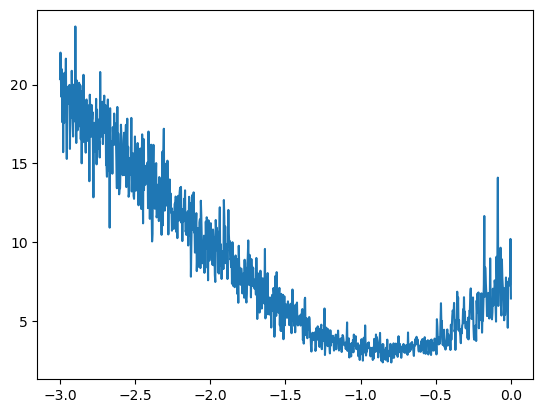

In [50]:
plt.plot(lr_i, loss_i)

One the `x`-axis we have the exponent of the learning rate.

We can see that the exponent of the learning rate that is good to use is roughly in the $[-1, -0.5]$ interval. Before that learning rate is too low, and after that the loss starts to explode. Andrej concluded that $-0.1$ is fairly a good exponent for the learning rate and $10^{-0.1} = 0.1$. Which means the initial guess of the $0.1$ was pretty good already. But this time, we know how to determine a good learning rate.

With this knowledge, we can once again update the training loop to reflect this, and this time increase the number of steps with the confidence that the learning rate is actually good.

In [51]:
# THE TRAINING LOOP
for i in range(10000):
    
    # Minibatch construct
    idx = torch.randint(0, X.shape[0], (32,))
    
    # Forward pass
    embed = C[X[idx]] # (32, 3, 2)
    h = torch.tanh(embed.view(-1, 6) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Y[idx])
    
    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # Update
    lr = 0.01
    for p in parameters:
        p.data += -lr * p.grad

# LOSS OVER ENTIRE DATASET
embed = C[X]
h = torch.tanh(embed.view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Y)
loss

tensor(2.5315, grad_fn=<NllLossBackward0>)

Running this model more than one gets to a loss that is better (i.e. lower) than the one bigram's which to recall was standing to $2.45$~$7$.

Andrej proposed to implement learning rate decay. Though this looks janky and is not how things happen in production, Andrej said, we first find a decent learning rate using the approach he showed us, then train the model for awhile. When the model is not learning very much and start to plateau, please like to decrease (i.e. decay) the loss by a factor of 10 and train the model for few more steps.

In this notebook, we started with `0.1` trained it for $30,000$ steps. Then decayed the learning rate to `0.01` and trained the network for an additional $40,000$ steps.

# Splitting up the dataset into train/val/test splits and why

We are acheiving a lower loss compared to the bigram model. But that is not exactly true, because the model is fairly small considering the number of parameters. The paramaters of this model will grow as we add more neurons to it. But as the network's parameters grow, so is its capacity to overfitting the training set. The result of that, will be a loss that gets close to almost zero like we saw before. And that's because the network is memorizing the examples of the training set, and sampling from it will just return examples from the training set. You want get any new data. In those circumstances, this is undesirable.

The standard in the field, Andrej said, is to split your data into three parts:

1. `training` (80%): Used to optimize the parameters of the neural network.

2. `dev` or `validation` (10)%: Use for development of hyperparameters such as the size of the hidden layer, the size of the size of the embedding, the strength of the regularization, etc. You can try different variations of the neural network and see which configuration of hyperparameters works best.

3. `test` (10%): Used to evaluate of the performance of the model at the end. We evaluate on this split very sparingly, and very few times because you'd start training also on this split. It exposes us to overfitting on this split as well, which is undesirable for our purposes.

Let's follow Andrej and split our datasets in those three parts.

In [52]:
# build the dataset
def build_dataset(words):  
    block_size = 3 # context length
    X, Y = [], []
    for w in words:
        #print(w)
        context = [0] * block_size
        for ch in w + '.':
          idx = stoi[ch]
          X.append(context)
          Y.append(idx)
          #print(''.join(itos[i] for i in context), '--->', itos[ix])
          context = context[1:] + [idx] # crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

X_train, Y_train = build_dataset(words[:n1])
X_dev, Y_dev = build_dataset(words[n1:n2])
X_test, Y_test = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


Now we reset the network, and also update the training loop to use the training set and not the entire dataset.

In [53]:
# THE MLP
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad =  True

In [54]:
# THE TRAINING LOOP
for i in range(10000):
    
    # Minibatch construct
    idx = torch.randint(0, X_train.shape[0], (32,))
    
    # Forward pass
    embed = C[X_train[idx]] # (32, 3, 2)
    h = torch.tanh(embed.view(-1, 6) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Y_train[idx])
    
    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # Update
    lr = 0.01
    for p in parameters:
        p.data += -lr * p.grad

In [55]:
# LOSS OVER DEV SET
embed = C[X_test]
h = torch.tanh(embed.view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Y_test)
loss

tensor(2.5766, grad_fn=<NllLossBackward0>)

I evaluated the loss over the dev after training the network (over the training set ) for $30,000$ steps with `0.1` learning, then for $10,000$ steps with `0.01` decayed learning rate, and was able to acheive a loss of `2.3` on the development set.

The examples in the dev set have never been seen by the network and yet it performed fairly well on this judjing from the loss, Andrej said. He suggested we also look at the loss over the training set as well:

In [56]:
# LOSS OVER TRAINING SET
embed = C[X_train]
h = torch.tanh(embed.view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Y_train)
loss

tensor(2.5751, grad_fn=<NllLossBackward0>)

The loss are similar indicating we are not overfitting, according to Andrej. He continued and also said the model does not have enough parameters to memorize the entire training set. So, far we are **underfitting**. Why? because the training loss and dev loss are roughly the **same**. This suggests that our the network is small, and scaling up the neural network will result in performance improvement. Let's do that.

# Experiment: Larger hidden layer

The easiest way to bump the size of our network is to increase the number of neurons in the hidden layer. Andrej increased it to $300$.

In [57]:
# THE MLP
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 300), generator=g) #NEW - 300 neurons
b1 = torch.randn(300, generator=g)
W2 = torch.randn((300, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad =  True

In [58]:
sum(p.nelement() for p in parameters) # the number of parameters in the network

10281

We now have slightly above 10,000 parameters in the network. Let's go ahead and try to train this new network.

In [71]:
# THE TRAINING LOOP

lr_i = [] # Learning rate for ith iteration
loss_i = [] # Loss for the ith iteration
step_i = []

for i in range(30000):
    
    # Minibatch construct
    idx = torch.randint(0, X_train.shape[0], (32,))
    
    # Forward pass
    embed = C[X_train[idx]] # (32, 3, 2)
    h = torch.tanh(embed.view(-1, 6) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Y_train[idx])
    
    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # Update
    lr = 0.1
    for p in parameters:
        p.data += -lr * p.grad
        
    # Track stats
    #lr_i.append(lr_exp[i])
    step_i.append(i)
    loss_i.append(loss.item())

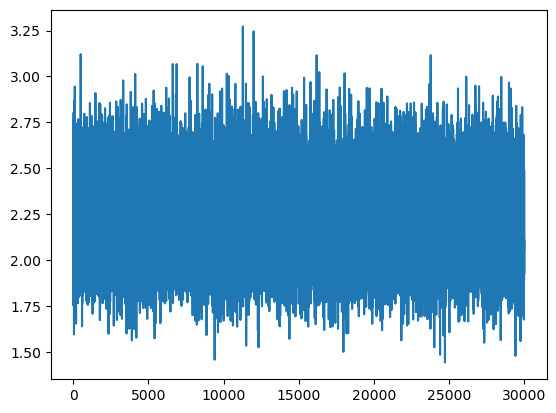

In [72]:
plt.plot(step_i, loss_i)

We first trained the network for 60,000 steps at learning rate `0.1`. Notice the how the loss decreases then goes up and down till the end. This is because we are optimizing over the minibatches. Another thing noise also is size of the batch (32 at the moment)... we may want to increase that later.

We then tried decrased the learning rate to `0.05`. And trained the network for an additional 30,000 steps

Let's compute the loss over the `dev` set. We repeatly trained and evaluated the model because we increased the model size so we trained multiple times to see the loss get lower than before, with the smaller model.

In [73]:
embed = C[X_dev]
h = torch.tanh(embed.view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Y_dev)
loss

tensor(2.2368, grad_fn=<NllLossBackward0>)

After training the network for awhile, and keep getting a kinda similar loss. Andrej said the bottlneck of the net's performance might be coming from the embedding size. It's $2$ at the moment. It might be too small. We may be cramming too many characters into just 2 dimensions and the neural net is not able to use the space efficiently... that might the thing holding back the model from performing better.

But before moving forward and increasing the embedding size, Andrej wants us to visualize the embeddings before increasing the dimensions.

# Visualizing the character embeddings

In this section, we are visualizing the embeddings that were trained by the neural net on these characters.

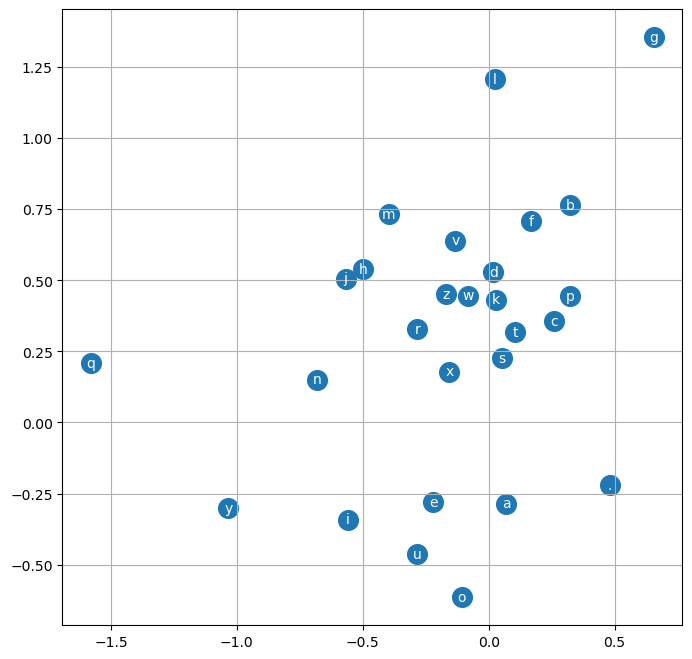

In [74]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

# Those clusterred close together are similar, and those far apart are dissimilar.
# Those furthest away are treated as exceptions.

What we see is quite interesting. the vowels `a`, `e`, `i`, `o`, `u` are forming a little cluster at the bottom. The neural networks treats them as similar and looks at them as interchangeable, Andrej explained. I can also see a cluster of mostly consonants as well. There are also cases like `q`, it is very far away. It has a special embedding vector, same of `g` as well. It is nice to see a little bit of structure, even for a simple embedding like we did. I am happy.

NOTE: This graph depends on the amounts of forward and backward passes performed during training. So, depending on that you might get a different graph.

# Experiment: Larger Embedding Size

We made the model bigger, and the loss improve just slightly. Andrej said the parameter preventing the network from performing better is the embedding size. So, in this section, we are doing that.

In [75]:
# THE MLP
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 10), generator=g) #NEW - EMBEDDING SIZE
W1 = torch.randn((30, 200), generator=g) #NEW - Reducing hidden layer from 300 to 200.
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad =  True

In [76]:
sum(p.nelement() for p in parameters)

11897

In [77]:
lr_i = []
loss_i = []
step_i = []

In [87]:
# THE TRAINING LOOP
for i in range(50000):
    
    # Minibatch construct
    idx = torch.randint(0, X_train.shape[0], (32,))
    
    # Forward pass
    embed = C[X_train[idx]]
    h = torch.tanh(embed.view(-1, 30) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y_train[idx])
    
    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # Update
    lr = 0.01
    for p in parameters:
        p.data += -lr * p.grad
        
    # Track stats
    #lr_i.append(lr_exp[i])
    step_i.append(i)
    loss_i.append(loss.log10().item())

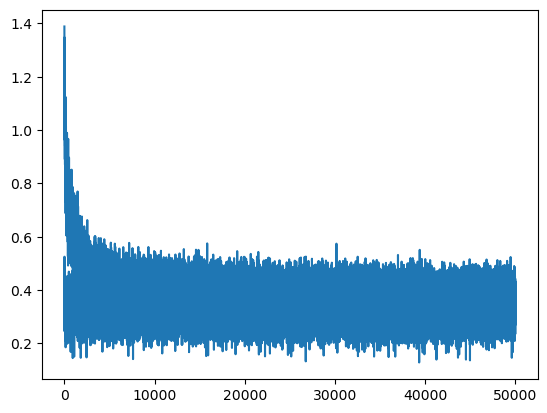

In [88]:
#plot the log loss instead of the loss to avoid the rocky stick appearance. The log squashes it
plt.plot(step_i, loss_i)

In [89]:
# LOSS TRAINING SET
embed = C[X_train]
h = torch.tanh(embed.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Y_train)
loss

tensor(2.1668, grad_fn=<NllLossBackward0>)

In [90]:
# LOSS DEV SET
embed = C[X_dev]
h = torch.tanh(embed.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Y_dev)
loss

tensor(2.1966, grad_fn=<NllLossBackward0>)

This new network was trained for:

50,000 - 0.1
50,000 - 0.01

After those two runs, the training loss was $2.1785$ and the dev loss was $2.2012$. These values started to depart a little from each other. Andrej said maybe the network is big enough that we are starting to overfit. So confirm his guess he decided to train the network for an additional 50,000 steps

50,000 - 0.01

After that the training loss was $2.1668$ and the dev loss was $2.1966$.

Andrej also said that this is not how you would find hyperparameters in production. Our method is mostly random. In practice you would run a lot of experiments, and select the values that perform best on the dev set... and test the performance on the model on the test set ONCE.

There are many ways to go from here, and maybe improve the model. We can continue tuning the optim, increase the embedding size, or increase the context size, etc.

# Summary of our final code, conclusion

In this section of the code, Andrej updated the training loop and trained again. But this time, here is also a an the code once again

In [93]:
# THE MLP
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 10), generator=g)
W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad =  True

In [94]:
sum(p.nelement() for p in parameters)

11897

In [95]:
lr_i = []
loss_i = []
step_i = []

In [96]:
for i in range(200000):
    
    # minibatch construct
    idx = torch.randint(0, X_train.shape[0], (32,))

    # forward pass
    emb = C[X_train[idx]] # (32, 3, 10)
    h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 200)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Y_train[idx])
    #print(loss.item())

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    #lr = lrs[i]
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    #lri.append(lre[i])
    step_i.append(i)
    loss_i.append(loss.log10().item())


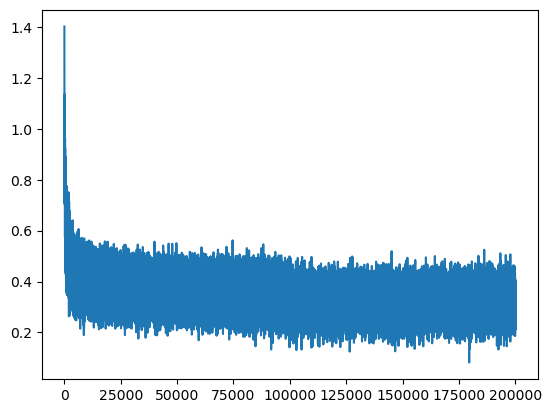

In [97]:
plt.plot(step_i, loss_i)

In [98]:
# LOSS TRAINING SET
embed = C[X_train]
h = torch.tanh(embed.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Y_train)
loss

tensor(2.1170, grad_fn=<NllLossBackward0>)

In [99]:
# LOSS DEV SET
embed = C[X_dev]
h = torch.tanh(embed.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Y_dev)
loss

tensor(2.1562, grad_fn=<NllLossBackward0>)

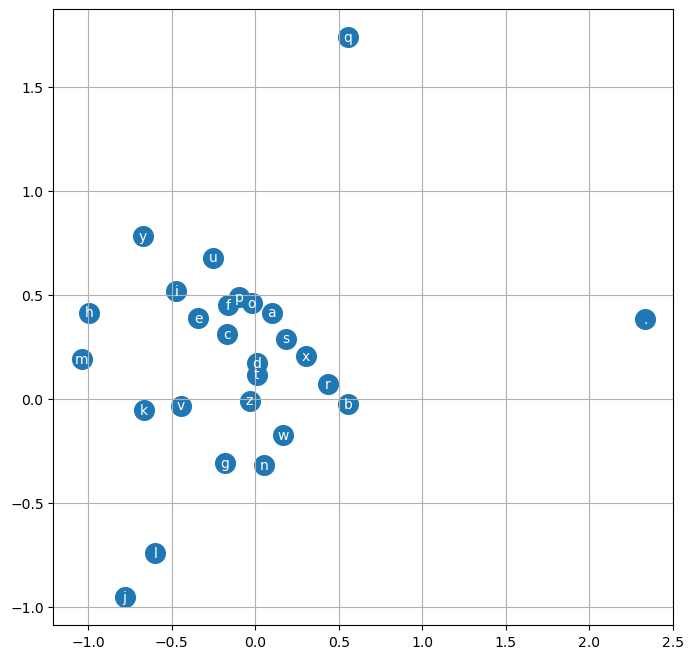

In [100]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

# Those clusterred close together are similar, and those far apart are dissimilar.
# Those furthest away are treated as exceptions.

# Sampling from the model

The last thing he wanted to show us is how to sample from this model, just like we did in `part-1`.

In [101]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
        emb = C[torch.tensor([context])] # (1,block_size,d)
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    
    print(''.join(itos[i] for i in out))

carlah.
amelle.
khy.
mili.
thil.
skanden.
jazhuen.
den.
art.
kaeli.
nermaritzieiah.
kaleigh.
ham.
pori.
quintis.
lilea.
jadiquosterrisharisi.
jaxen.
druan.
edde.


Whoah, unlike the bigram model, this MLP model generated words that sounds more human-like. It's pretty cool! This model performs better. This is an improvement :)